In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import h5py
%matplotlib inline

mat_names = glob.glob('./project_datasets/*.mat')
# each test subject got a different file - 9 test subjects
print(mat_names)

['./project_datasets/A07T_slice.mat', './project_datasets/A08T_slice.mat', './project_datasets/A09T_slice.mat', './project_datasets/A03T_slice.mat', './project_datasets/A04T_slice.mat', './project_datasets/A01T_slice.mat', './project_datasets/A05T_slice.mat', './project_datasets/A06T_slice.mat', './project_datasets/A02T_slice.mat']


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
matfile = h5py.File(mat_names[0], 'r')
print(matfile.keys()) #image and type

[u'image', u'type']


In [3]:
image_mat = matfile['image']
image_shape = image_mat.shape # 288 (48x6) trials across 25 electrodes for 1000 time points (250Hz*4s)
print image_shape

(288, 25, 1000)


In [4]:
type_mat = matfile['type']
type_shape = type_mat.shape
print type_shape
# plt.plot(type_mat[0,:288]) # gets the significant values of types
# all the 0's occur after 288, and are meaningless I think
# so the image_mat, which has shape (288, 25, 1000) should correspond
# to the first 288 entries of type_mat, so
# for a single subject, training data should be image_mat, with 288 samples, each sample has shape (25, 1000)
# and our target label matrix should be type_mat[:288] (or 287?)

(1, 1000)


In [5]:
nans = np.sum(np.isnan(image_mat[:,:]))
print(nans) #No NaN in the data
print len(image_mat[0:,:])
count = 0
# for i in range(len(image_mat[0:,:])):
#  if np.sum(np.isnan(image_mat[i:,:])):
#         pass

0
288


In [6]:
type_set = list(set(type_mat[0,:]))
print(type_set) 

[0.0, 769.0, 770.0, 771.0, 772.0]


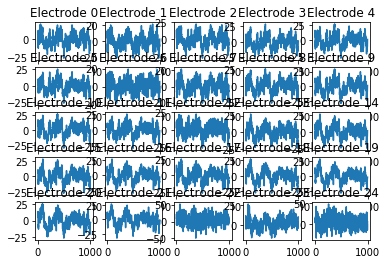

In [7]:
for i in range(image_shape[1]):
    plt.subplot(image_shape[1]**0.5,image_shape[1]**0.5,i+1)
    plt.plot(matfile['image'][0,i,:])
    plt.title("Electrode " + str(i))
    plt.rcParams["figure.figsize"] = [20,20]

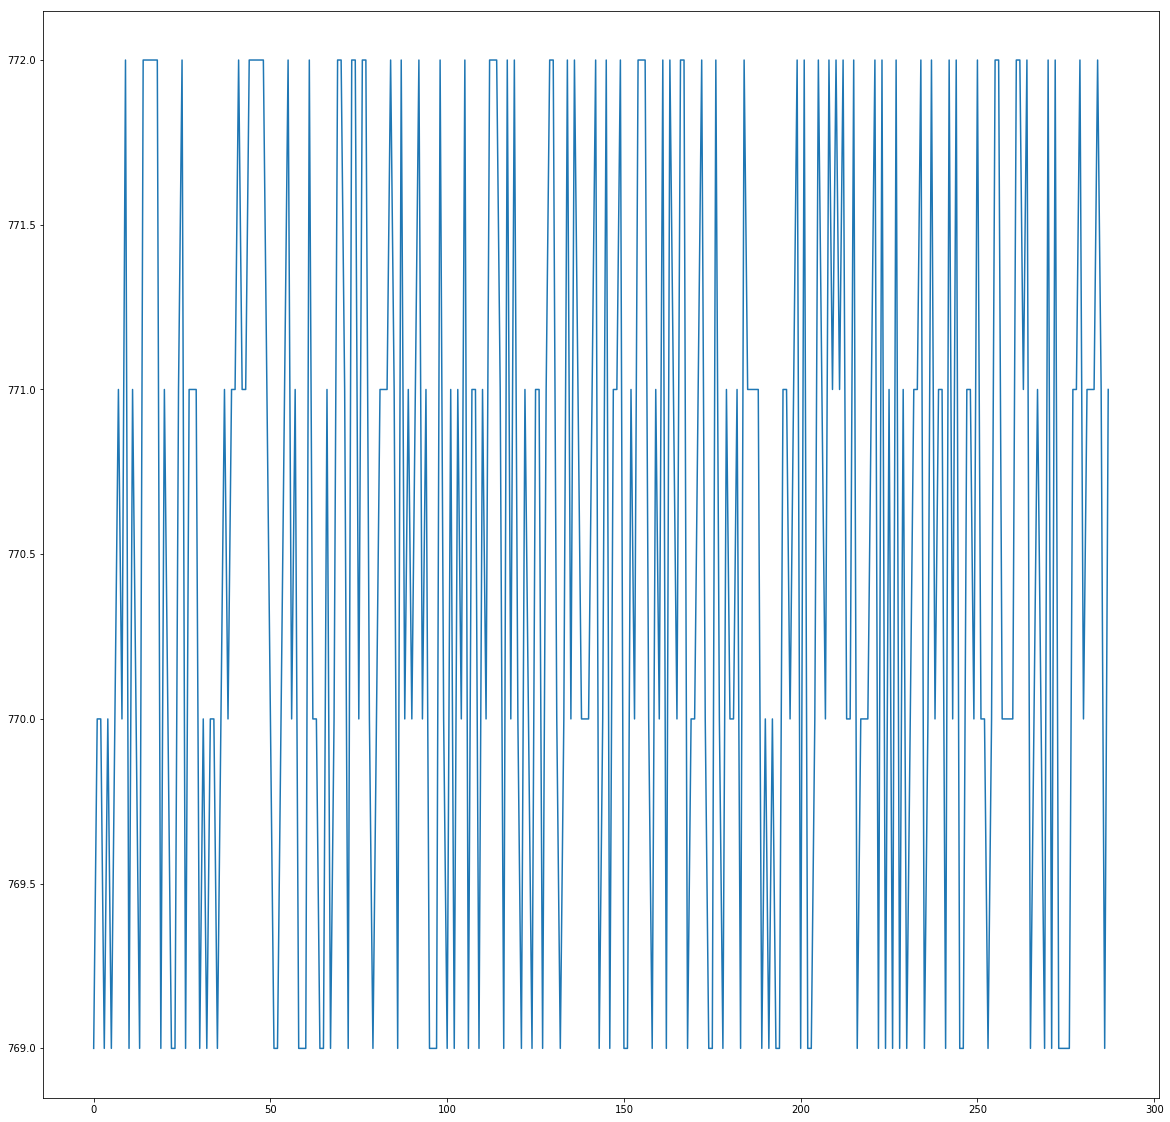

In [8]:
plt.plot(matfile['type'][0,:image_shape[0]])

In [9]:
EEG_channels = 22 #from project guidelines
test_count = 50 #from project guideline, 238 for train-validation and 50 for test
validation_count = 38 # 38 points in validation set and remaining 200 points in test set

In [10]:
#setting seed
np.random.seed(seed=1337)
test_picked = np.random.choice(image_shape[0], test_count, replace=False)
train_val_picked = np.setdiff1d(np.arange(image_shape[0]), test_picked)
val_picked = train_val_picked[:validation_count]
train_picked = train_val_picked[validation_count:]

In [11]:
trainval_data_X = []
training_data_X = []
validation_data_X = []
test_data_X = []

trainval_data_Y = []
training_data_Y = []
validation_data_Y = []
test_data_Y = []

for i in range(len(mat_names)):
    matfile = h5py.File(mat_names[i], 'r')
    
    trainval_data_X.append(matfile['image'][sorted(train_val_picked),:EEG_channels,:]) #(238, 22, 1000) x 9
    training_data_X.append(matfile['image'][sorted(train_picked),:EEG_channels,:]) #(200, 22, 1000) x 9
    validation_data_X.append(matfile['image'][sorted(val_picked),:EEG_channels,:]) #(38, 22, 1000) x 9
    test_data_X.append(matfile['image'][sorted(test_picked),:EEG_channels,:]) #(50, 22, 1000) x 9
    
    trainval_data_Y.append(matfile['type'][0,sorted(train_val_picked)] - type_set[1]) #(238, ) x 9
    training_data_Y.append(matfile['type'][0,sorted(train_picked)] - type_set[1]) #(200, ) x 9
    validation_data_Y.append(matfile['type'][0,sorted(val_picked)] - type_set[1]) #(38, ) x 9
    test_data_Y.append(matfile['type'][0,sorted(test_picked)] - type_set[1]) #(50, ) x 9

In [12]:
for i in range(len(mat_names)):
    assert(set(training_data_Y[i]) == set(validation_data_Y[i])) #check whether we have data for all labels 
    assert(set(training_data_Y[i]) == set(test_data_Y[i])) #check whether we have data for all labels 

In [13]:
training_data_shape = training_data_X[0].shape
print(training_data_shape) #(200, 22, 1000) while test data shape is (50, 22, 1000) and validation data is (38, 22,1000)

(200, 22, 1000)


In [14]:
print(training_data_Y[0].shape)

(200,)


In [15]:
from functools import reduce

def remove_nan_rows_A(A, b):
    if (np.isnan(A).any() or np.isnan(b).any()):
        mask = ~np.isnan(np.sum(A,axis=(1,2))) & ~np.isnan(b[:])
        A = A[mask, :, :]
        b = b[mask]
        
    assert A.shape[0] == b.shape[0]
    return A, b


cnn_trainval_data_X = reduce((lambda x, y: np.concatenate((x, y), axis=0)), trainval_data_X) #(2142, 22, 1000) 
cnn_training_data_X = reduce((lambda x, y: np.concatenate((x, y), axis=0)), training_data_X) #(1800, 22, 1000)
cnn_validation_data_X = reduce((lambda x, y: np.concatenate((x, y), axis=0)), validation_data_X) #(342, 22, 1000)
cnn_test_data_X = reduce((lambda x, y: np.concatenate((x, y), axis=0)), test_data_X) #(450, 22, 1000)

cnn_trainval_data_Y = reduce((lambda x, y: np.concatenate((x, y), axis=0)), trainval_data_Y) #(2142, )
cnn_training_data_Y = reduce((lambda x, y: np.concatenate((x, y), axis=0)), training_data_Y) #(1800, )
cnn_validation_data_Y = reduce((lambda x, y: np.concatenate((x, y), axis=0)), validation_data_Y) #(342, )
cnn_test_data_Y = reduce((lambda x, y: np.concatenate((x, y), axis=0)), test_data_Y) #(450,)


cnn_training_data_X, cnn_training_data_Y = remove_nan_rows_A(cnn_training_data_X, cnn_training_data_Y)
cnn_validation_data_X, cnn_validation_data_Y = remove_nan_rows_A(cnn_validation_data_X, cnn_validation_data_Y)

cnn_test_data_X, cnn_test_data_Y = remove_nan_rows_A(cnn_test_data_X, cnn_test_data_Y)

In [40]:
print cnn_training_data_X.shape
print cnn_training_data_Y.shape

(1775, 22, 1000)
(1775,)


In [33]:
import sklearn
from sklearn import svm

In [36]:
svm_training_X = np.reshape(cnn_training_data_X, (1775, 22000))
svm_training_Y = cnn_training_data_Y

In [37]:
clf = svm.SVC()
clf.fit(svm_training_X, svm_training_Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [41]:
svm_test_X = np.reshape(cnn_validation_data_X, (340, 22000))
svm_test_Y = cnn_validation_data_Y
predicted = clf.predict(svm_test_X)

print(predicted)

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.

In [31]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
print(torch.__version__)

0.4.0a0+4c4a42b


In [18]:
# Hyper Parameters
num_epochs = 20
batch_size = 10
learning_rate = 3e-4

# # MNIST Dataset
# train_dataset = dsets.MNIST(root='./data/',
#                             train=True, 
#                             transform=transforms.ToTensor(),
#                             download=True)

# test_dataset = dsets.MNIST(root='./data/',
#                            train=False, 
#                            transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                            batch_size=batch_size, 
#                                            shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=batch_size, 
#                                           shuffle=False)

# train_concat = np.hstack((cnn_trainval_data_X, cnn_trainval_data_Y.reshape(2142,1)))
# test_concat = np.append(cnn_test_data_X, cnn_test_data_Y, 1)

# print train_concat.shape
# print test_concat.shape

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(22, 32, kernel_size=5, padding=2, stride=1), #32x1000
            nn.BatchNorm1d(32), 
            nn.ReLU(),
            nn.MaxPool1d(2)) #32 x 500
        self.layer2 = nn.Sequential(
            nn.Conv1d(32, 8, kernel_size=4, padding=1, stride=2), #8x250
            nn.BatchNorm1d(8),
            nn.ReLU()) #8x250
        self.fc1 = nn.Sequential(
            nn.Linear(2000, 100), #100
            nn.BatchNorm1d(100),
            nn.ReLU())
        self.fc2 = nn.Linear(100, 4)
        
    #basic forward - go through two conv layers + fc layer
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
# #         self.layer1 = nn.Sequential(
# #             nn.Conv1d(22, 128, kernel_size=5, padding=2, stride=1), #128x1000
# #             nn.BatchNorm1d(128), 
# #             nn.ReLU(),
# #             nn.MaxPool1d(2)) #128 x 500
# #         self.layer2 = nn.Sequential(
# #             nn.Conv1d(128, 128, kernel_size=5, padding=1, stride=2), #8x250
# #             nn.BatchNorm1d(128),
# #             nn.ReLU()) #128x250
#         self.fc1 = nn.Sequential(
#             nn.Linear(22*1000, 22*100), #100
#             nn.BatchNorm1d(22*100),
#             nn.ReLU())
#         self.fc2 = nn.Sequential(
#             nn.Linear(22*100, 1000), #100
#             nn.BatchNorm1d(1000),
#             nn.ReLU())
#         self.fc3 = nn.Sequential(
#             nn.Linear(1000, 100), #100
#             nn.BatchNorm1d(100),
#             nn.ReLU())
#         self.fc4 = nn.Linear(100, 4)
        
    #basic forward - go through two conv layers + fc layer
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
#         print x.shape
        out = self.fc1(out)
        out = self.fc2(out)
#         out = self.fc3(out)
#         out = self.fc4(out)
        return out

cnn = CNN()

for i in cnn.parameters():
    print i.shape

torch.Size([32, 22, 5])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([8, 32, 4])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([100, 2000])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([4, 100])
torch.Size([4])


In [20]:
tensor_x_train = torch.Tensor(cnn_training_data_X)
tensor_y_train = torch.LongTensor(cnn_training_data_Y)

print tensor_x_train.shape
print tensor_y_train.shape

tensor_x_val = torch.Tensor(cnn_validation_data_X)
tensor_y_val = torch.LongTensor(cnn_validation_data_Y)

torch.Size([1775, 22, 1000])
torch.Size([1775])


In [21]:
train_dataset = torch.utils.data.TensorDataset(tensor_x_train,tensor_y_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_val,tensor_y_val)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [22]:
print len(train_loader)
print len(val_loader)

178
34


In [27]:
import torch

cnn = CNN()

# Loss and Optimizer

#Can also try nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

train_acc = []
val_acc = []
loss_history = []
          
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
    #     for i in range(cnn_training_data_X.shape[0]):
        images = Variable(images, requires_grad=True) #unsqueeze used to make a 4d tensor because 
    #     print images.shape
        labels = Variable(labels)

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss_history.append(loss)
        loss.backward()
        optimizer.step()

        if (i+1) % 20 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(cnn_training_data_X.shape)//batch_size, loss.data[0]))
    
    images = Variable(torch.Tensor(cnn_training_data_X))
    labels = torch.LongTensor(cnn_training_data_Y)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0) #1800
#     print (predicted == labels).sum().int()
#     print type((predicted == labels).sum().int())
    correct = (predicted == labels).sum()
    print(correct)
    print('Train Accuracy: %d %%' % (100.0 * int(correct) / float(total)))
    train_acc.append((100.0 * int(correct) / float(total)))

    cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    images = Variable(torch.Tensor(cnn_validation_data_X))
    labels = torch.LongTensor(cnn_validation_data_Y)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum()
    print('validation Accuracy: %d %%' % (100.0 * int(correct) / float(total)))
    val_acc.append((100.0 * int(correct) / float(total)))

/home/cdli/.local/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/20], Iter [20/0] Loss: 1.3360
Epoch [1/20], Iter [40/0] Loss: 1.2796
Epoch [1/20], Iter [60/0] Loss: 1.4019
Epoch [1/20], Iter [80/0] Loss: 1.4043
Epoch [1/20], Iter [100/0] Loss: 1.2038
Epoch [1/20], Iter [120/0] Loss: 1.2615
Epoch [1/20], Iter [140/0] Loss: 1.3558
Epoch [1/20], Iter [160/0] Loss: 1.4717

 69
[torch.ByteTensor of size ()]

Train Accuracy: 3 %
validation Accuracy: 39 %
Epoch [2/20], Iter [20/0] Loss: 0.9998
Epoch [2/20], Iter [40/0] Loss: 1.1313
Epoch [2/20], Iter [60/0] Loss: 1.0703
Epoch [2/20], Iter [80/0] Loss: 0.9435
Epoch [2/20], Iter [100/0] Loss: 1.0713
Epoch [2/20], Iter [120/0] Loss: 1.2384
Epoch [2/20], Iter [140/0] Loss: 1.0493
Epoch [2/20], Iter [160/0] Loss: 1.4523

 191
[torch.ByteTensor of size ()]

Train Accuracy: 10 %
validation Accuracy: 45 %
Epoch [3/20], Iter [20/0] Loss: 0.6290
Epoch [3/20], Iter [40/0] Loss: 0.5803
Epoch [3/20], Iter [60/0] Loss: 1.2101
Epoch [3/20], Iter [80/0] Loss: 0.8637
Epoch [3/20], Iter [100/0] Loss: 0.9816
Epoch 

In [29]:
# Test the Model
cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
images = Variable(torch.Tensor(cnn_test_data_X))
labels = torch.LongTensor(cnn_test_data_Y)
outputs = cnn(images)
_, predicted = torch.max(outputs.data, 1)
total += labels.size(0)
correct += (predicted == labels).sum()

print('Test Accuracy of the model on the 10000 test images: %d %%' % (100.0 * int(correct) / float(total)))

Test Accuracy of the model on the 10000 test images: 44 %


[3.887323943661972, 10.76056338028169, 12.169014084507042, 5.126760563380282, 11.943661971830986, 13.408450704225352, 13.408450704225352, 13.408450704225352, 13.408450704225352, 13.464788732394366, 13.464788732394366, 13.464788732394366, 13.464788732394366, 13.464788732394366, 13.464788732394366, 13.464788732394366, 13.464788732394366, 13.464788732394366, 13.464788732394366, 13.464788732394366]


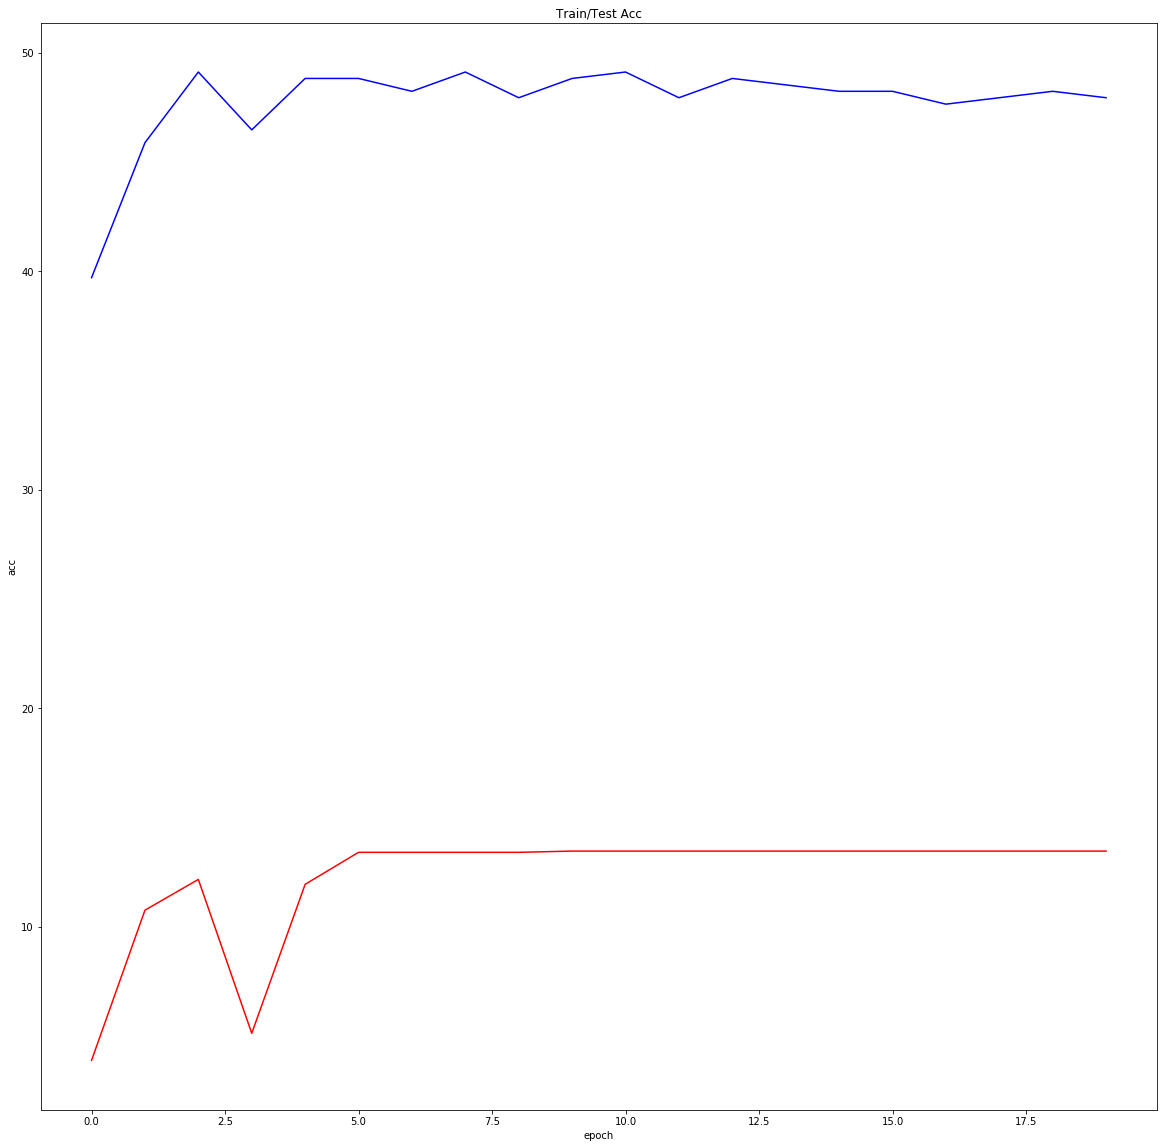

In [32]:
#plot train/val accuracies
print train_acc
plt.title("Train/Test Acc")
plt.xlabel("epoch")
plt.ylabel('acc')
plt.plot(train_acc, color='red')
plt.plot(val_acc, color='blue')
plt.show()